In [1]:
import numpy as np
import time 
from scipy.spatial.distance import cdist

# D -> distances between points
# X0 -> initial random points
# nodes -> number of points

In [2]:
def compute_D(X):
    return cdist(X, X, 'euclidean')

In [3]:
def compute_V(W):
    nodes = W.shape[0]
    if W is None:
        W = np.ones((nodes, nodes)) - np.eye(nodes)
    return np.diag(np.sum(W, axis=1)) - W

In [4]:
# compute Guttman Transform matrix
def compute_B(dist, D, W):
    dist[dist == 0] = 1e-15  
    ratio = D / dist
    print
    weights_times_S = W * ratio
    B = np.diag(weights_times_S.sum(axis=1)) - weights_times_S
    
    return B

In [5]:
# compute stress
def compute_S(D, dist, W):
    error_matrix = W * (D - dist)**2
    return np.sum(np.triu(error_matrix, k=1))

In [6]:
def smacof_anchors(D, X0, n_anchors, W, params):
    Z = X0;
    X = X0;
    nodes = D.shape[0]
    n = nodes - n_anchors
    
    dist = compute_D(X0)
    V = compute_V(W)

    V11 = V[:n, :n]
    V12 = V[:n, n:]
    V11_p = np.linalg.pinv(V11)

    old_stress = None
    for iii in range(params.max_iter):
        B = compute_B(dist, D, W)
        B11 = B[:n, :n]
        B12 = B[:n, n:]

        Z1 = Z[:n, :]
        Z2 = Z[n:, :]
        X2 = X0[n:, :]

        X1 = V11_p @ (B11 @ Z1 + B12 @ Z2 - V12 @ X2)
        X = np.vstack((X1, X2))

        dist = compute_D(X)
        S = compute_S(D, dist, W)

        Z = X
    
        if S < params.atol: 
            break    
        if old_stress is not None:
            if abs(old_stress - S) < params.rtol:
                break
        old_stress = S
    return X


In [7]:
class MDSParam:
    def __init__(self):
        self.max_iter = 400
        self.rtol = 1e-6
        self.atol = 1e-3

In [8]:
X_anchors = np.array([[6, 6, 0], [4, 4, 0], [5, 5, 0], [1, 3, 0]])
X_targets = np.array([[0, 0, 0], [3, 3, 0], [2, 2, 0], [1, 1, 0]])
n_targets = X_targets.shape[0]
n_anchors = X_anchors.shape[0]

# distances
X_real = np.concatenate((X_targets, X_anchors),  axis = 0)
nodes = X_real.shape[0]
D = cdist(X_real, X_real, 'euclidean')

# weights
W = np.ones((nodes, nodes))
W[0:n_targets, 0:n_targets] = 0.2
W[0:n_targets, n_targets:] = 0.7
W[n_targets:, 0:n_targets] = 0.7
np.fill_diagonal(W, 0)

X0 = np.vstack([np.random.rand(n_targets, 3) * 10, X_anchors])
X = smacof_anchors(D, X0, n_anchors, W, MDSParam())
print(X)

[[-0.19882013  0.41760047  1.37129702]
 [ 2.97290392  3.05568022  0.31952607]
 [ 1.93430852  2.1360786   0.61591978]
 [ 0.87208998  1.26908683  0.99168333]
 [ 6.          6.          0.        ]
 [ 4.          4.          0.        ]
 [ 5.          5.          0.        ]
 [ 1.          3.          0.        ]]


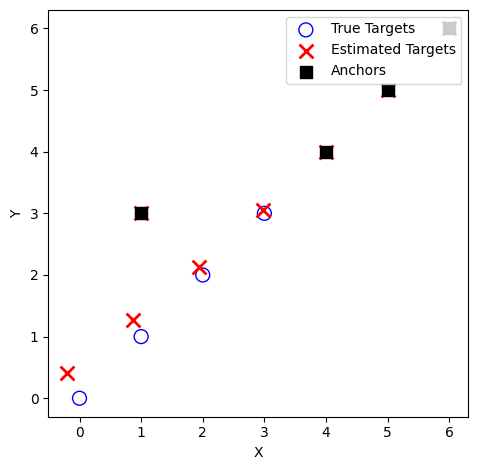

In [9]:
import matplotlib.pyplot as plt

# 1. Initialize plot without a fixed figsize (or use a ratio)
fig, ax = plt.subplots()

# 2. Plot True Targets (Blue Hollow Circles)
ax.scatter(X_targets[:, 0], X_targets[:, 1], s=100, 
           edgecolors='b', facecolors='none', label='True Targets')

# 3. Plot Estimated Targets (Red X's)
n_t = X_targets.shape[0]
ax.scatter(X[:, 0], X[:, 1], s=100, 
           c='r', marker='x', linewidths=2, label='Estimated Targets')

# 4. Plot Anchors (Black Squares)
ax.scatter(X_anchors[:, 0], X_anchors[:, 1], s=80, 
           c='k', marker='s', label='Anchors')

# 5. AUTO-SIZE LOGIC
ax.axis('scaled')    # Forces the plot to scale 1:1 and fit all data points
ax.set_xlabel('X')
ax.set_ylabel('Y')

# 6. Styling
ax.legend(loc='upper right')
plt.tight_layout()   # Adjusts the padding around the figure automatically

plt.show()